[consejos google pro](https://colab.research.google.com/notebooks/pro.ipynb)

# SEGMENTACION MEDIANTE U-NET + VGG16 y


    def dice_loss(y_true, y_pred, smooth=1e-5):
      y_true = tf.cast(y_true, tf.float32)
      intersection = tf.reduce_sum(y_true * y_pred)
      suma = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
      dice_score = (2.0 * intersection + smooth) / (suma + smooth)
      dice_loss = 1.0 - dice_score
      return dice_loss

## 1.4 Codigo

In [ ]:
# EL DATA AUGMENTATION QUE VA ES EL DE ESTA NOTEBOOK


## Imports
import os
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras


## Seeding
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
from PIL import Image

def image_display(image_pathlist, mask_pathlist, index):
    # input: image and mask filepath and the index
    # output matplotlib images
    image = Image.open(image_pathlist[index]).convert("L") #agregamos .convert("L")
    imagearray = np.array(image)
    print('Image shape: ', imagearray.shape)


    mask = Image.open(mask_pathlist[index]).convert("L") #agregamos .convert("L")
    maskarray = np.array(mask)
    print('Mask shape: ', maskarray.shape)

    #fig, ax = plt.subplots(3,figsize=(5,10))
    fig, ax = plt.subplots(1,3,figsize=(14,4)) #cambié para que se vean horizontales
    ax[0].imshow(imagearray, aspect='auto', cmap='gray')
    ax[1].imshow(maskarray, aspect='auto', cmap='gray')
    ax[2].imshow(imagearray, aspect='auto', cmap = 'gray')
    ax[2].imshow(maskarray, cmap = 'Reds', aspect='auto', alpha = 0.4)

In [ ]:
def finetune_unfreezeall(base_model):
    base_model = base_model

    # unfreeze the contracting path and freeze the expanding path
    for layer in base_model.layers:
        if layer.name in ['block1_conv1', 'block1_conv2', 'block1_pool',
                          'block2_conv1', 'block2_conv2', 'block2_pool',
                          'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool',
                          'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool',
                          'block5_conv1', 'block5_conv2', 'block5_conv3']:
            layer.trainable = True

    return base_model

## Clase para Aumentacion de datos completa, con esquinas y doble flip

In [ ]:
class DataAugmentation:
    def __init__(self, images):
        self.images = images
        self.output = []

    def process_images(self):
        image_files = self.images
        for file_name in image_files:
            image = file_name
            if image.shape[0] < 512:
                diff_rows = 512 - image.shape[0]
                image = np.vstack((image, np.zeros((diff_rows, image.shape[1]), dtype=np.uint8)))

            if image.shape[1] < 512:
                diff_cols = 512 - image.shape[1]
                image = np.hstack((image, np.zeros((image.shape[0], diff_cols), dtype=np.uint8)))

            self.apply_transformations(image)


    def apply_transformations(self, image):



        for i in range(-4,0,4):   #range(-4,5,2)=[-4,-2, 0, 2, 4]
          for j in range(-4,0,4):  #range(-4,5,4)=[-4, 0, 4]
            translate = self.apply_translation(image, 32 * i, 32 * j)
            translated_cropped = self.adjust_image_size(translate, 512, 512)
            self.save_transformed_images(translated_cropped)

            flip_horizontal_right = cv2.flip(translated_cropped, 1)
            self.save_transformed_images(flip_horizontal_right)

            flip_vertical_right = cv2.flip(translated_cropped, 0)
            self.save_transformed_images(flip_vertical_right)

            flip_both_right = cv2.flip(flip_horizontal_right, 0)  #agregado!
            self.save_transformed_images(flip_both_right)     #agregado!



    def apply_translation(self, image, x_offset, y_offset):
        rows, cols = image.shape
        M = np.float32([[1, 0, x_offset], [0, 1, y_offset]])
        translated_image = cv2.warpAffine(image, M, (cols, rows))
        return translated_image

    def save_transformed_images(self, image):

        self.output.append(image)

    def save_image(self, image):
        self.output.append(image)


    def adjust_image_size(self, image, target_width, target_height):
        height, width = image.shape
        x_offset = (width - target_width) // 2
        y_offset = (height - target_height) // 2
        new_image = image[y_offset:y_offset + target_height, x_offset:x_offset + target_width]

        return new_image



In [ ]:
def image_comparac(monocroma, etiqueta, red):
    # input: image and mask filepath and the index
    # output matplotlib images

    fig, ax = plt.subplots(1,4,figsize=(16,4)) #cambié para que se vean horizontales
    ax[0].imshow(monocroma, aspect='auto', cmap='gray')
    ax[0].set_title('monocroma')
    ax[1].imshow(etiqueta, aspect='auto', cmap='gray')
    ax[1].set_title('Ground Truth')
    ax[2].set_title('Predicción')
    ax[2].imshow(red, aspect='auto', cmap = 'gray')
    ax[3].imshow(monocroma, aspect='auto', cmap='gray')
    ax[3].imshow(etiqueta, cmap = 'Reds', aspect='auto', alpha = 0.4)
    ax[3].imshow(red, cmap = 'Blues', aspect='auto', alpha = 0.4)

## Leer las imagenes

In [ ]:
# Este comando es para leer los archivos directamente desde Drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
path_train = "/content/drive/MyDrive/Proyecto_Sadosky/base_final/clean_database/train"
path_test = "/content/drive/MyDrive/Proyecto_Sadosky/base_final/clean_database/test"


In [ ]:
#database_path = os.path.join(path_train, "clean_png_train")
database_path = path_train

files_train = os.listdir(database_path)

images_train = [item for item in files_train if 'labeled' not in item]


random.shuffle(images_train)

print(f'Total number of Train images: {len(images_train)}')
print(images_train)


train_ids = images_train

Total number of Train images: 493
['150.png', '182.png', '241.png', '111.png', '319.png', '279.png', '205.png', '343.png', '42.png', '137.png', '390.png', '444.png', '3.png', '220.png', '429.png', '59.png', '376.png', '35.png', '491.png', '30.png', '226.png', '53.png', '456.png', '163.png', '95.png', '37.png', '404.png', '323.png', '432.png', '311.png', '9.png', '51.png', '355.png', '145.png', '423.png', '158.png', '303.png', '347.png', '389.png', '33.png', '199.png', '257.png', '2.png', '388.png', '386.png', '113.png', '295.png', '460.png', '339.png', '217.png', '225.png', '72.png', '123.png', '58.png', '310.png', '31.png', '189.png', '66.png', '327.png', '99.png', '431.png', '139.png', '276.png', '146.png', '4.png', '218.png', '479.png', '285.png', '223.png', '19.png', '234.png', '503.png', '430.png', '351.png', '380.png', '365.png', '152.png', '177.png', '122.png', '70.png', '334.png', '368.png', '299.png', '284.png', '235.png', '353.png', '82.png', '332.png', '16.png', '471.png', '

In [ ]:
train_images = []
train_masks = []

for image_id in train_ids:


    image_path = os.path.join(database_path, str(image_id))
    train_images.append(image_path)
    mask_path = os.path.join(database_path, image_id.replace(".png","")) + "_labeled.png"
    train_masks.append(mask_path)

## Cargo las imagenes en memoria

In [ ]:
Xtrain = []

Ytrain = []


for image_id in train_ids:


    image_path = os.path.join(database_path, str(image_id))
    mask_path = os.path.join(database_path, image_id.replace(".png","")) + "_labeled.png"
    image = cv2.imread(image_path, 0)
    mask = cv2.imread(mask_path, 0)
    Xtrain.append(image)
    Ytrain.append(mask)


In [ ]:
# hacemos la aumentacion de datos de train

X_train_data_augmentation = DataAugmentation(Xtrain)
X_train_data_augmentation.process_images()


In [ ]:
Xtrain =  X_train_data_augmentation.output


In [ ]:
X_train = np.asarray(Xtrain, dtype=np.uint8)
print('Xtrain:',X_train.shape)



Xtrain: (1972, 512, 512)


In [ ]:
Y_train_data_augmentation = DataAugmentation(Ytrain)
Y_train_data_augmentation.process_images()

In [ ]:
Ytrain = Y_train_data_augmentation.output

In [ ]:
print(Y_train_data_augmentation.output[1].shape)

(512, 512)


In [ ]:
Y_train = np.asarray(Ytrain, dtype=bool)
print('Ytrain:',Y_train.shape)


Ytrain: (1972, 512, 512)


In [ ]:
len(X_train)

1972

## Metricas para medir el desempeno de la red

In [ ]:
import tensorflow.keras.backend as K

# intersection over union

def jacard_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = K.sum(y_true * y_pred)

    return (intersection + 1.0) / (K.sum(y_true) + K.sum(y_pred) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

In [ ]:
def jacard_coef_np(y_true, y_pred):
  y_true=y_true.astype('float32')
  y_pred=y_pred.astype('float32')
  intersection = np.sum(y_true * y_pred)
  return (intersection + 1.0) / (np.sum(y_true) + np.sum(y_pred) - intersection + 1.0)

In [ ]:
def dice_coef_np(y_true, y_pred):
  y_true=y_true.astype('float32')
  y_pred=y_pred.astype('float32')
  intersection = np.sum(y_true * y_pred)
  return (2*intersection + 1.0) / (np.sum(y_true) + np.sum(y_pred) + 1.0)

In [ ]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = K.sum(y_true * y_pred)
    suma = K.sum(y_true) + K.sum(y_pred)
    dice = (2.0 * intersection + smooth) / (suma + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [ ]:
import tensorflow as tf
# este no funciona

def dice_loss_modif0(y_true, y_pred, smooth=1e-5):
    y_true = tf.cast(y_true, tf.float32)

    if sum(y_true) == 0:               #se agrega para controlar los falsos positivos cuando no hay placa en el Ground Truth
      # no tengo placa
      dice_loss = tf.reduce_sum(y_pred) * smooth #en nuestro caso también puede ser /(512**2)

    else:
      intersection = tf.reduce_sum(y_true * y_pred)
      suma = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
      dice_score = (2.0 * intersection + smooth) / (suma + smooth)
      dice_loss = 1.0 - dice_score

    return dice_loss

In [ ]:
import tensorflow as tf
# este no funciona bien para smooth=1e-5

def dice_loss_modif(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_score = (2.0 * intersection + smooth) / (union + smooth)
    dice_loss = - dice_score+(tf.reduce_sum(y_pred)*smooth)**2
    return dice_loss

In [ ]:
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1e-5):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    suma = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_score = (2.0 * intersection + smooth) / (suma + smooth)
    dice_loss = 1.0 - dice_score
    return dice_loss

In [ ]:
def weighted_binary_crossentropy(y_true, y_pred):

    one_weight = 0.89
    zero_weight = 0.11
    # Original binary crossentropy (see losses.py):
    # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Calculate the binary crossentropy
    y_true = tf.cast(y_true, tf.float32)
    b_ce = K.binary_crossentropy(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weighted_b_ce = weight_vector * b_ce

    # Return the mean error
    return K.mean(weighted_b_ce)

## Modelo de Red neuronal

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import concatenate, Conv2DTranspose, Conv2D, Dropout
from keras.layers import Input
from keras.models import Model


# https://github.com/dorltcheng/Transfer-Learning-U-Net-Deep-Learning-for-Lung-Ultrasound-Segmentation/blob/main/V_Unet/V_Unet_v1_1.ipynb

from tensorflow.keras.regularizers import l2

def TL_unet_model(input_shape, dropout_rate=0.5, l2_penalty=1e-3):
    # input: input_shape (height, width, channels)
    # return model

    img_input = Input(shape=(input_shape, input_shape, 1))
    img_conc = concatenate(([img_input, img_input, img_input]))


    base_VGG = VGG16(include_top = False,
                   weights = "imagenet",
                   input_tensor=img_conc)

    # freezing all layers in VGG16
    for layer in base_VGG.layers:
        layer.trainable = False

    # the bridge (exclude the last maxpooling layer in VGG16)
    # bridge = base_VGG.get_layer("block5_conv3").output

    bridge = base_VGG.output

    print(bridge.shape)

    # Decoder now
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    print(up1.shape)
    concat_1 = concatenate([up1, base_VGG.get_layer("block5_conv3").output], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = Dropout(dropout_rate)(conv6)

    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    print(up2.shape)
    concat_2 = concatenate([up2, base_VGG.get_layer("block4_conv3").output], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(dropout_rate)(conv7)

    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    print(up3.shape)
    concat_3 = concatenate([up3, base_VGG.get_layer("block3_conv3").output], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(dropout_rate)(conv8)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    print(up4.shape)
    concat_4 = concatenate([up4, base_VGG.get_layer("block2_conv2").output], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Dropout(dropout_rate)(conv9)

    # probando
    up5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv9)
    print(up5.shape)
    concat_5 = concatenate([up5, base_VGG.get_layer("block1_conv2").output], axis=3)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat_5)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv10)
    conv10 = Dropout(dropout_rate)(conv10)

    conv11 = Conv2D(1, (1, 1), activation='sigmoid')(conv10)
    print(conv11.shape)

    model = Model(inputs=[base_VGG.input], outputs=[conv11])

    return model

In [ ]:
from tensorflow.keras.optimizers import Adam

# NOTA: cuando uso "adam", sin especificar el Learning rate, el algoritmo no converge y hace todo mal

# model = model_build_func((512, 512, 1),1,True)
model = TL_unet_model(512)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=[dice_loss], metrics=[jacard_coef])
# model.compile(optimizer="sgd", loss=[dice_loss], metrics=[jacard_coef])
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
(None, 16, 16, 512)
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 128)
(None, 256, 256, 64)
(None, 512, 512, 32)
(None, 512, 512, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 512, 512, 3)          0         ['input_1[0][0]',             
                                                                     'input_1[0][0]',             
                                                                     'input_1[0][0]']             
                                                                                   

## Entrenamiento

## path resultados del modelo

In [ ]:
path='/content/drive/MyDrive/Proyecto_Sadosky/modelo_final/resultados/VGG16_1/'

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
## Validation Data Size  80:20

epochs = 15
batch_size = 16 # con 32 me da error

checkpoint_path = path+'unet_plaque_segmentation.hdf5'

model_checkpoint = ModelCheckpoint(checkpoint_path,
                                    verbose=1,
                                    monitor='val_loss',
                                    save_best_only=True)

callbacks_list = [model_checkpoint]

results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, callbacks=callbacks_list)


Epoch 1/15
99/99 [==============================] - ETA: 0s - loss: 0.7674 - jacard_coef: 0.1394
Epoch 1: val_loss improved from inf to 0.62903, saving model to /content/drive/MyDrive/Proyecto_Sadosky/modelo_final/resultados/VGG16/unet_plaque_segmentation.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


99/99 [==============================] - 275s 2s/step - loss: 0.7674 - jacard_coef: 0.1394 - val_loss: 0.6290 - val_jacard_coef: 0.2380
Epoch 2/15
99/99 [==============================] - ETA: 0s - loss: 0.5474 - jacard_coef: 0.2969
Epoch 2: val_loss improved from 0.62903 to 0.57423, saving model to /content/drive/MyDrive/Proyecto_Sadosky/modelo_final/resultados/VGG16/unet_plaque_segmentation.hdf5
99/99 [==============================] - 166s 2s/step - loss: 0.5474 - jacard_coef: 0.2969 - val_loss: 0.5742 - val_jacard_coef: 0.2834
Epoch 3/15
99/99 [==============================] - ETA: 0s - loss: 0.4998 - jacard_coef: 0.3379
Epoch 3: val_loss improved from 0.57423 to 0.56254, saving model to /content/drive/MyDrive/Proyecto_Sadosky/modelo_final/resultados/VGG16/unet_plaque_segmentation.hdf5
99/99 [==============================] - 166s 2s/step - loss: 0.4998 - jacard_coef: 0.3379 - val_loss: 0.5625 - val_jacard_coef: 0.2928
Epoch 4/15
99/99 [==============================] - ETA: 0s - 

In [ ]:

#from tensorflow.keras.models import load_model
#checkpoint_path = path+'unet_plaque_segmentation.hdf5'

#model = load_model(checkpoint_path,
#                     custom_objects={'dice_loss': dice_loss, 'jacard_coef': jacard_coef})

## Ver desempeno de la red

## visualizamos curvas de entrenamiento

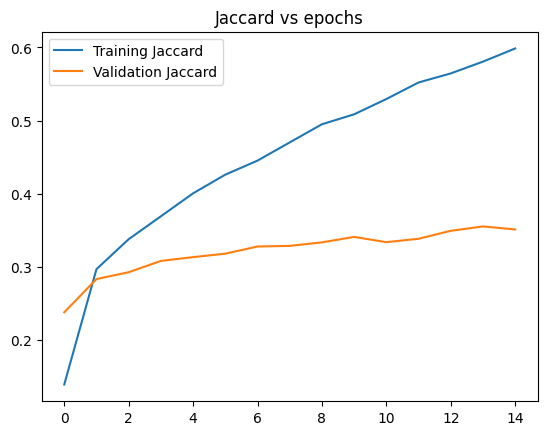

In [ ]:
## visualizamos curvas de entrenamiento

plt.figure()
plt.title("Jaccard vs epochs")
plt.plot( results.history['jacard_coef'] )
plt.plot( results.history['val_jacard_coef'] )
plt.legend(['Training Jaccard', 'Validation Jaccard'])
plt.show()

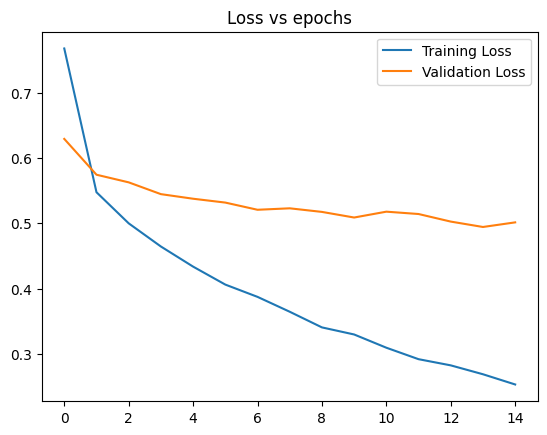

In [ ]:
plt.figure()
plt.title("Loss vs epochs")
plt.plot( results.history['loss'] )
plt.plot( results.history['val_loss'] )
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [ ]:
l=results.history['loss']
path_loss=path+'history_loss.txt'
np.savetxt(path_loss, l)

vl=results.history['val_loss']
path_v_loss=path+'history_val_loss.txt'
np.savetxt(path_v_loss, vl)


In [ ]:
l=results.history['jacard_coef']
path_J=path+'history_Jaccard.txt'
np.savetxt(path_J, l)

vl=results.history['val_jacard_coef']
path_v_J=path+'history_val_Jaccard.txt'
np.savetxt(path_v_J, vl)


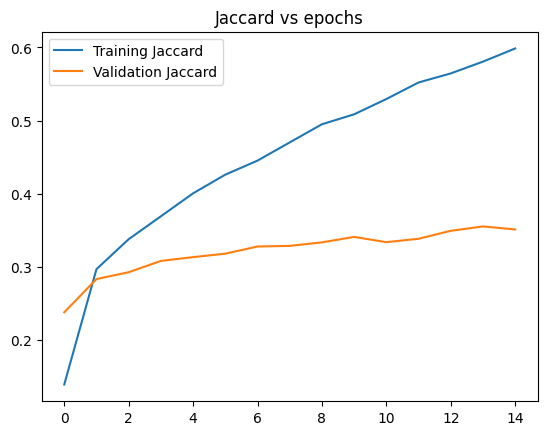

<Figure size 640x480 with 0 Axes>

In [ ]:
## visualizamos curvas de entrenamiento

plt.figure()
plt.title("Jaccard vs epochs")
plt.plot( results.history['jacard_coef'] )
plt.plot( results.history['val_jacard_coef'] )
plt.legend(['Training Jaccard', 'Validation Jaccard'])
plt.show()
path1=path+"Jaccard_vs_epochs.png"
plt.savefig(path1)

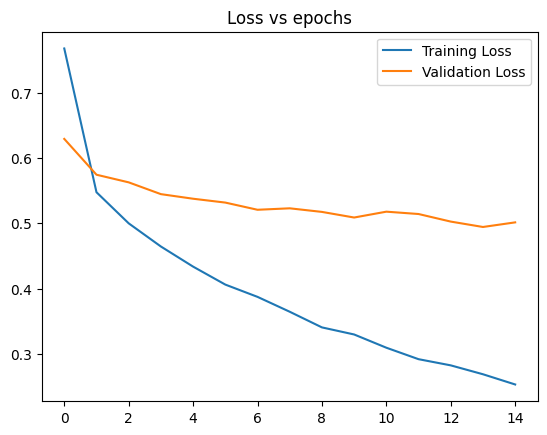

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure()
plt.title("Loss vs epochs")
plt.plot( results.history['loss'] )
plt.plot( results.history['val_loss'] )
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()
path2=path+"DICE_Loss_vs_epochs.png"
plt.savefig(path2)

# Test

In [ ]:
#database_path_test = os.path.join(path_test, "clean_png_test")
database_path_test = path_test

files_test = os.listdir(database_path_test)

images_test = [item for item in files_test if 'labeled' not in item]

print(f'Total number of Test images: {len(images_test)}')
print(images_test)

test_ids = images_test

Total number of Test images: 48
['504.png', '505.png', '509.png', '506.png', '510.png', '507.png', '511.png', '508.png', '513.png', '517.png', '516.png', '512.png', '515.png', '521.png', '519.png', '518.png', '523.png', '522.png', '524.png', '528.png', '527.png', '526.png', '529.png', '525.png', '531.png', '530.png', '534.png', '533.png', '532.png', '535.png', '537.png', '536.png', '540.png', '538.png', '539.png', '543.png', '541.png', '542.png', '550.png', '547.png', '551.png', '546.png', '552.png', '548.png', '544.png', '549.png', '545.png', '520.png']


In [ ]:
Xtest = []
Ytest = []

for image_id in test_ids:

    image_path = os.path.join(database_path_test, str(image_id))
    mask_path = os.path.join(database_path_test, image_id.replace(".png","")) + "_labeled.png"
    image = cv2.imread(image_path, 0)
    mask = cv2.imread(mask_path, 0)
    print(image.shape)
    print(mask.shape)
    Xtest.append(image[144:656, 144:656]) #eligimos el centro de tam 512x512
    Ytest.append(mask[144:656, 144:656]) #eligimos el centro de tam 512x512

(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(800, 800)
(480, 390)
(480, 390)
(480, 390)
(480, 390)
(480, 390)
(480, 390)
(480, 390)
(480, 390)
(480, 390)
(480, 390)
(480, 390)
(480, 390)
(480, 390)
(480, 390)
(480, 390)

In [ ]:
#armar nueva lista
centro_x= 400
centro_y=400

for r in range(len(test_ids)):
  h,w=Xtest[r].shape
  imagenvieja=Xtest[r]

  if h<800 or w<800:
    imagen_auxiliar=np.zeros((800,800),dtype='uint8')
    top_y=(800-h)//2
    left_x=(800-w)//2
    bottom_y = top_y + h
    right_x = left_x+w
    imagen_auxiliar[top_y:bottom_y, left_x:right_x] = imagenvieja
    imagenvieja=imagen_auxiliar


  Xtest[r]= imagenvieja[144:656, 144:656]# 512x512 centrado


In [ ]:
#armar nueva lista
centro_x= 400
centro_y=400

for r in range(len(test_ids)):
  h,w=Ytest[r].shape
  imagenvieja=Ytest[r]

  if h<800 or w<800:
    imagen_auxiliar=np.zeros((800,800),dtype='uint8')
    top_y=(800-h)//2
    left_x=(800-w)//2
    bottom_y = top_y + h
    right_x = left_x+w
    imagen_auxiliar[top_y:bottom_y, left_x:right_x] = imagenvieja
    imagenvieja=imagen_auxiliar


  Ytest[r]= imagenvieja[144:656, 144:656]# 512x512 centrado

In [ ]:
Y_test = np.asarray(Ytest, dtype=bool)
print('Ytrain:',Y_test.shape)


Ytrain: (48, 512, 512)


In [ ]:
len(Xtest)

48

In [ ]:
X_test = np.asarray(Xtest, dtype=np.uint8)
print('Xtest:',X_test.shape)

Y_test = np.asarray(Ytest, dtype=bool)
print('Ytest:',Y_test.shape)

r = random.randint(0, len(X_test)-1)

print(X_test[r].shape)
print(Y_test[r].shape)

Xtest: (48, 512, 512)
Ytest: (48, 512, 512)
(512, 512)
(512, 512)


## Predichos para test

In [ ]:
preds = model.predict(X_test[0:270])

2/2 [==============================] - 1s 1s/step


In [ ]:
print(preds.shape)

(48, 512, 512, 1)


In [ ]:
## Save the Weights
#model.save_weights("UNetW.h5")

result = preds

# aca tenemos que binarizar la prediccion del modelo
result = result > 0.5

In [ ]:
print(result.shape)

(48, 512, 512, 1)


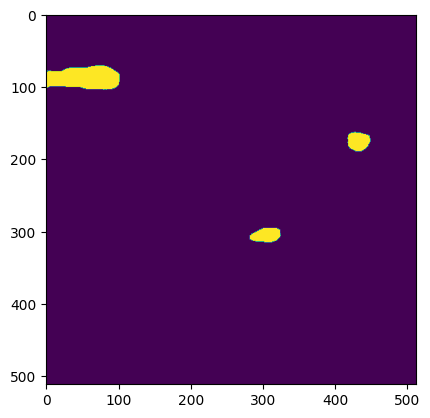

In [ ]:
plt.imshow(result[1,:,:,0])

imagen523.png
Jaccard: 0.3138060719568594
DICE: 0.47766562653264494


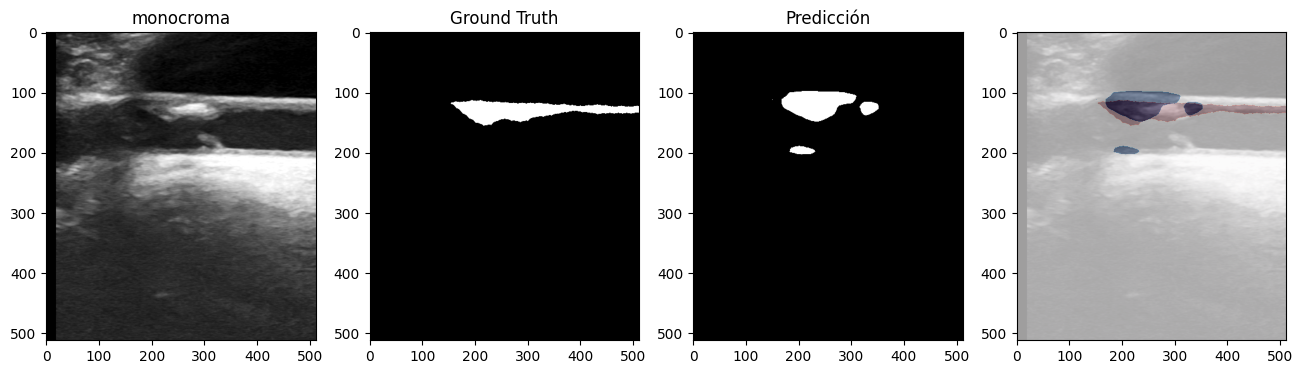

In [ ]:
item = random.randint(0, len(images_test)-1)
item = 16
monocroma=X_test[item]
etiqueta=Y_test[item]
red=preds[item]
print('imagen'+test_ids[item])
image_comparac(monocroma, etiqueta, red)
print('Jaccard:', jacard_coef_np(Y_test[item], preds[item][:,:,0]))
print('DICE:',dice_coef_np(Y_test[item], preds[item][:,:,0]))


In [ ]:
item = random.randint(0, len(images_test)-1)
item = 16
monocroma=X_test[item]
etiqueta=Y_test[item]
red=preds[item]
print('imagen'+test_ids[item])
image_comparac(monocroma, etiqueta, red)
print('Jaccard:', jacard_coef_np(Y_test[item], preds[item][:,:,0]))
print('DICE:',dice_coef_np(Y_test[item], preds[item][:,:,0]))


In [ ]:
n=len(images_test)
for item in range(n):
  monocroma=X_test[item]
  etiqueta=Y_test[item]
  red=preds[item]
  print('imagen'+test_ids[item])
  image_comparac(monocroma, etiqueta, red)
  fname=path+'resultado_imagen_Test_'+test_ids[item]
  plt.savefig(fname)


In [ ]:
n=len(images_test)
for item in range(n):
  monocroma=X_test[item]
  etiqueta=Y_test[item]
  red=preds[item]
  print('imagen'+test_ids[item])
  image_comparac(monocroma, etiqueta, red)
  fname=path+'resultado_imagen_Test_'+test_ids[item]
  plt.savefig(fname)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print('Jaccard:',jacard_coef_np(Y_test, preds[:,:,0]))
print('DICE:',dice_coef_np(Y_test, preds[:,:,0]))
print('Global')


In [ ]:
D=0.0
J=0.0
for item in range(n):
  J=J+jacard_coef_np(Y_test[item], preds[item][:,:,0])
  D=D+dice_coef_np(Y_test[item], preds[item][:,:,0])

J=J/20
D=D/20

print('Promedio en Test')
print('Jaccard:',J)
print('DICE:',D)


## Predichos para train

In [ ]:
pred_train = model.predict(X_train[0:m])

In [ ]:
resul_train=pred_train >0.5

In [ ]:
m=len(images_train)
D=0.0
J=0.0
for item in range(m):
  J=J+jacard_coef_np(Y_train[item], pred_train[item][:,:,0])
  D=D+dice_coef_np(Y_train[item], pred_train[item][:,:,0])

J=J/m
D=D/m

print('Promedio en Train')
print('Jaccard:',J)
print('DICE:',D)

In [ ]:
item = random.randint(0, n-1)
#item = 16
monocroma=X_train[item]
etiqueta=Y_train[item]
red=pred_train[item]
print('imagen'+str(item))
image_comparac(monocroma, etiqueta, red)
print('Jaccard:',jacard_coef_np(Y_train[item], pred_train[item][:,:,0]))
print('DICE:',dice_coef_np(Y_train[item], pred_train[item][:,:,0]))

In [ ]:
item = random.randint(0, n-1)
#item = 16
monocroma=X_train[item]
etiqueta=Y_train[item]
red=pred_train[item]
print('imagen'+str(item))
image_comparac(monocroma, etiqueta, red)
print('Jaccard:',jacard_coef_np(Y_train[item], pred_train[item][:,:,0]))
print('DICE:',dice_coef_np(Y_train[item], pred_train[item][:,:,0]))